In [92]:
%matplotlib inline
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [93]:
DEFAULT_IMAGES_DIR = "scraper/images/training"
DEFAULT_BATCH_SIZE = 64
DEFAULT_NO_EPOCHS = 10
DEFAULT_MODEL_PATH = "model.h5"

## Helper functions
Set of helper functions

In [94]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [95]:
class Config:
    def __init__(self, images_dir, batch_size, epochs, *args, **kwargs):
        self.images_dir = images_dir
        self.train_batch_size = batch_size
        self.train_number_epochs = epochs
        
config = Config(DEFAULT_IMAGES_DIR, DEFAULT_BATCH_SIZE, DEFAULT_NO_EPOCHS)

# Custom Dataset

In [96]:
class SiameseNetworkDataset(Dataset):
    """ 
    Get the dataset for the network, the aim is to get image pairs randomly where 50% 
    image pairs belong to the same class and 50% to a different class
    """
    def __init__(self, imageFolderDataset, transform=None, should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        """ we need to make sure approx 50% of images are in the same class """
        should_get_same_class = np.random.random()
        should_get_same_class = np.where(should_get_same_class > 0.5, 1, 0)

        if should_get_same_class:
            img1_tuple = img0_tuple
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(should_get_same_class)], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# Load Dataset

In [97]:
images_folder_dataset = datasets.ImageFolder(root=config.images_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=images_folder_dataset,
                                    transform=transforms.Compose([transforms.ToTensor()])
                                   ,should_invert=False)

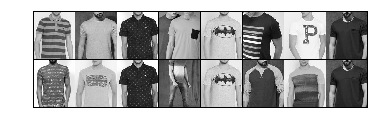

[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [98]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# Net

In [99]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*130*150, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [100]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [101]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=config.train_batch_size)

In [102]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [103]:
counter = []
loss_history = [] 
iteration_number= 0

In [104]:
config.train_number_epochs

10

Epoch number 0
 Current loss 1.6916987895965576

Epoch number 0
 Current loss 7.16138219833374

Epoch number 0
 Current loss 3.030468225479126

Epoch number 0
 Current loss 2.981921672821045

Epoch number 0
 Current loss 1.709784984588623

Epoch number 0
 Current loss 1.6964621543884277

Epoch number 0
 Current loss 1.5212854146957397

Epoch number 0
 Current loss 1.5631178617477417

Epoch number 0
 Current loss 3.3700475692749023

Epoch number 0
 Current loss 1.797656536102295

Epoch number 0
 Current loss 1.3197749853134155

Epoch number 0
 Current loss 1.8885587453842163

Epoch number 0
 Current loss 1.5088779926300049

Epoch number 0
 Current loss 1.8082667589187622

Epoch number 0
 Current loss 1.3351953029632568

Epoch number 0
 Current loss 1.218659520149231



C:\Users\arush\Anaconda3\envs\tf-gpu\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch number 1
 Current loss 1.4428515434265137

Epoch number 1
 Current loss 1.724435567855835

Epoch number 1
 Current loss 1.3288389444351196

Epoch number 1
 Current loss 1.4208157062530518

Epoch number 1
 Current loss 1.4719924926757812

Epoch number 1
 Current loss 1.423974633216858

Epoch number 1
 Current loss 1.3876359462738037

Epoch number 1
 Current loss 1.4136950969696045

Epoch number 1
 Current loss 1.4843097925186157

Epoch number 1
 Current loss 1.6651008129119873

Epoch number 1
 Current loss 1.2972679138183594

Epoch number 1
 Current loss 1.209784984588623

Epoch number 1
 Current loss 1.3067890405654907

Epoch number 1
 Current loss 1.22272527217865

Epoch number 1
 Current loss 1.21593177318573

Epoch number 1
 Current loss 1.6893274784088135

Epoch number 2
 Current loss 1.4953513145446777

Epoch number 2
 Current loss 1.7462317943572998

Epoch number 2
 Current loss 1.294219732284546

Epoch number 2
 Current loss 1.4236375093460083

Epoch number 2
 Current loss

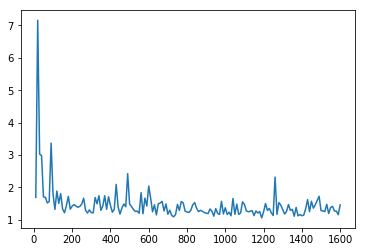

In [105]:
for epoch in range(0, config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    torch.save(net, DEFAULT_MODEL_PATH)
show_plot(counter,loss_history)

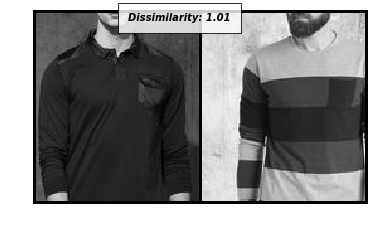

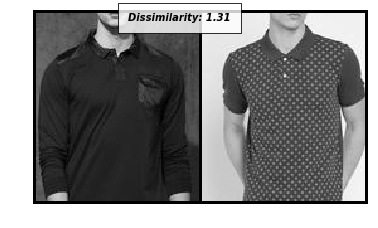

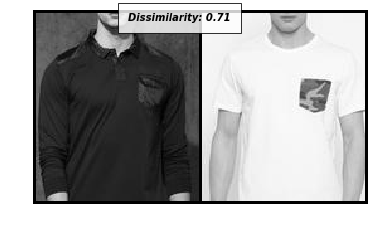

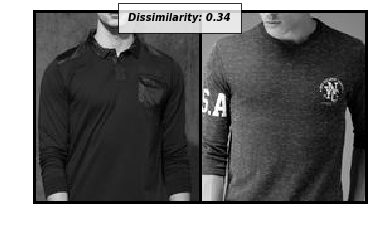

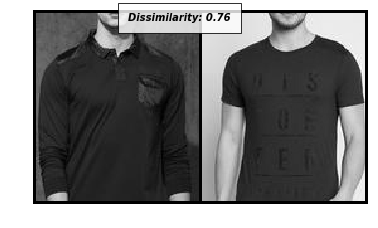

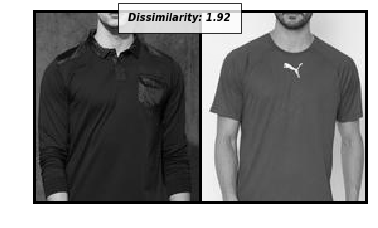

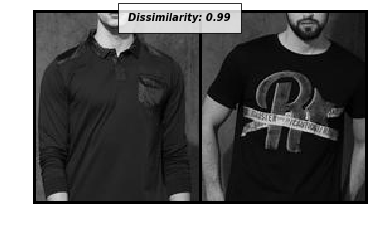

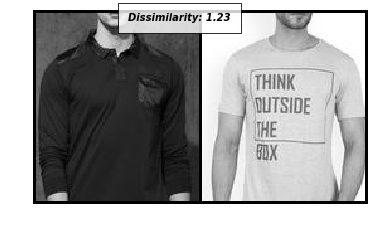

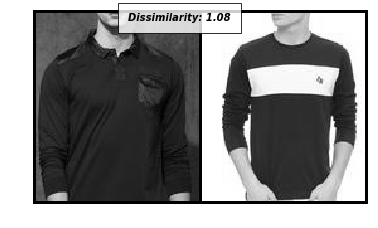

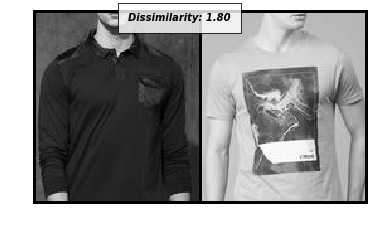

In [106]:
folder_dataset_test = datasets.ImageFolder(root=config.images_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.ToTensor()])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

